In [3]:
#need to automate go analysis with david
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_venn as mplv
import os
from math import *
from subprocess import *
import pybedtools as pbt
from glob import glob
import seaborn as sns
import statsmodels.formula.api as sm
import csv
import re
import scipy.stats as ss
csv.register_dialect("textdialect",delimiter='\t')
%matplotlib inline
mpl.rc("lines", markeredgewidth=0.5)


/home/sam/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [4]:
#What are the specific things I want to do GO on?
#Just do biological process to keep it simple
#differentially expressed genes during EMT (Twist) and hnRNPM knockdown
#differentiall expressed splicing during EMT (Twist) and hnRNPM knockdown

In [5]:
#PARSE rMATS SE Code
#May want to check with Anna about my genomic intervals operations
def parse_rMATS_SE(filename,read_cutoff):
    '''This function will parse rMATS output in filename to output only events that meet an
    FDR cutoff and PSI cutoff. The output include both positive and negative delta PSI as well
    as each separated
    Input: filename, FDR_cutoff which is a float 0-1, and PSI cutoff which is a float > 1, and read_cutoff which is and int'''
    rMATS_file = open(filename).readlines()
    rMATS_list = []
    for line in rMATS_file:
        line = line.strip().split('\t')
        fixed_line = []
        for x in line:
            x = x.strip('"')
            fixed_line.append(x)
        rMATS_list.append(fixed_line)
    #add a new column to the list withe the splice ID
    #Note - I would like to figure out how to do this with an existing dataframe
    for item in rMATS_list[0:1]:
        item.insert(0,"splice_id")
    for item in rMATS_list[1:]:
        splice_id = str(item[3]+':'+item[7]+'-'+item[8]+':'+item[5]+'-'+item[6]+':'+item[9]+'-'+item[10]+':'+item[4]+":"+item[2])
        item.insert(0,splice_id)
    #add new columns for sample_1_read_number and sample_2_read_number
    for item in rMATS_list[0:1]:
        item.insert(15,"SAMPLE_1_AVERAGE_READ")
    for item in rMATS_list[1:]:
        sample_1_ic_list = item[13].strip().split(',')
        sample_1_ic_numbers = [int(x) for x in sample_1_ic_list]
        sample_1_sc_list = item[14].strip().split(',')
        sample_1_sc_numbers = [int(x) for x in sample_1_sc_list]
        sample_1_average_read = np.mean(sample_1_ic_numbers) + np.mean(sample_1_sc_numbers)
        item.insert(15,sample_1_average_read)
    for item in rMATS_list[0:1]:
        item.insert(18,"SAMPLE_2_AVERAGE_READ")
    for item in rMATS_list[1:]:
        sample_2_ic_list = item[16].strip().split(',')
        sample_2_ic_numbers = [int(x) for x in sample_2_ic_list]
        sample_2_sc_list = item[17].strip().split(',')
        sample_2_sc_numbers = [int(x) for x in sample_2_sc_list]
        sample_2_average_read = np.mean(sample_2_ic_numbers) + np.mean(sample_2_sc_numbers)
        item.insert(18,sample_2_average_read)    
    #add new column for enhance or silence effect
    for item in rMATS_list[0:1]:
        item.append("splicing_factor_effect")
    for item in rMATS_list[1:]:
        if float(item[-1]) < 0:
            item.append("silence")
        else:
            item.append("enhance")
    #add new columns to have the mean of the PSI values since it is a comma separate list
    for item in rMATS_list[0:1]:
        item.insert(24,"inc_level_1_mean")
    for item in rMATS_list[1:]:
        mean = item[23].strip().split(',')
        mean_no_na = filter(lambda x: x != "NA",mean)
        mean_numbers = [float(i) for i in mean_no_na]
        mean_value = np.mean(mean_numbers)
        item.insert(24,mean_value)
    for item in rMATS_list[0:1]:
        item.insert(26,"inc_level_2_mean")
    for item in rMATS_list[1:]:
        mean = item[25].strip().split(',')
        mean_no_na = filter(lambda x: x != "NA",mean)
        mean_numbers = [float(i) for i in mean_no_na]
        mean_value = np.mean(mean_numbers)
        item.insert(26,mean_value)
    #Remove scaffold chromosomes:
    c_list = ['chrX','chr13','chr12','chr11','chr10','chr17','chr16','chr15','chr14','chr19','chr18','chr22','chr20','chr21','chr7','chr6','chr5','chr4','chr3','chr2','chr1','chr9','chr8']
    for item in rMATS_list[1:]:
        if item[4] not in c_list:
            rMATS_list.remove(item)
    #write this file as a csv for easier import into pandas. Then import it
    with open('tempfile','wb') as temp:
        tempwriter = csv.writer(temp,delimiter='\t')
        for item in rMATS_list:
            tempwriter.writerow(item)
    with open('tempfile') as temp:
        rMATS_df = pd.read_csv(temp,sep='\t')
    os.remove('tempfile')
    #Fix Gene ID so it is just the ens_ID
    rMATS_df['ens_gene'] = rMATS_df.GeneID.str.split('.').str[0]
    #Append ens_gene to splice ID
    rMATS_df['splice_id'] = rMATS_df['splice_id'].astype('str') + ':' + rMATS_df['ens_gene'].astype('str')
    #remove samples less than read cutoff. This means that each sample must have inc + exc >= read cutoff
    rMATS_df = rMATS_df[rMATS_df.SAMPLE_1_AVERAGE_READ >= read_cutoff]
    rMATS_df = rMATS_df[rMATS_df.SAMPLE_2_AVERAGE_READ >= read_cutoff]
    
#     #remove FDR > FDR_cutoff
#     rMATS_df = rMATS_df[rMATS_df.FDR < FDR_cutoff]
#     #remove those beneath delta PSI cutoff
#     rMATS_df = rMATS_df[rMATS_df.IncLevelDifference.abs() >= PSI_cutoff]
    return rMATS_df

In [51]:
twist_rMATS_df_filtered.head()

,splice_id,ID,GeneID,geneSymbol,chr,strand,exonStart_0base,exonEnd,upstreamES,upstreamEE,...,SkipFormLen,PValue,FDR,IncLevel1,inc_level_1_mean,IncLevel2,inc_level_2_mean,IncLevelDifference,splicing_factor_effect,ens_gene
0,chr3:9985064-9985199:9985585-9985779:9986048-9...,10031,ENSG00000163703.17_2,CRELD1,chr3,+,9985585,9985779,9985064,9985199,...,99,0.0,0.0,0.270,0.270,0.065,0.065,0.205,enhance,ENSG00000163703
1,chr7:5229818-5230124:5232748-5232802:5239206-5...,10074,ENSG00000157954.14_1,WIPI2,chr7,+,5232748,5232802,5229818,5230124,...,99,0.0,0.0,0.147,0.147,0.434,0.434,-0.287,silence,ENSG00000157954
3,chr11:57505079-57505140:57505307-57505498:5750...,10157,ENSG00000213593.9_2,TMX2,chr11,+,57505307,57505498,57505079,57505140,...,99,0.0,0.0,0.781,0.781,0.639,0.639,0.142,enhance,ENSG00000213593
4,chr8:145759512-145759586:145763104-145763197:1...,10299,ENSG00000147799.11_1,ARHGAP39,chr8,-,145763104,145763197,145759512,145759586,...,99,0.0,0.0,0.683,0.683,0.983,0.983,-0.300,silence,ENSG00000147799
8,chr17:33984617-33984810:33997875-33997917:3399...,10417,ENSG00000006125.16_2,AP2B1,chr17,+,33997875,33997917,33984617,33984810,...,99,0.0,0.0,0.242,0.242,0.346,0.346,-0.104,silence,ENSG00000006125


In [6]:
%%time
#load in the skipped exon files as variable for the rMATS analysis: Just do the new rMATS first
twist = '/media/sam/Data2/bcm_star_alignments/SEH_bcm/rMATS_3_2_5_results/SEH-1_SEH-2_with_gencode_25lift37/MATS_output/SEH-1_SEH-2_rMATS_3_2_5_SE_ROT'
cc1_cc2 = '/media/sam/Data2/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-1_CC-2/MATS_output/CC-1_CC-2_rMATS_3_2_5_SE_ROT'
cc3_cc4 = '/media/sam/Data2/bcm_star_alignments/CC_bcm/rMATS_3_2_5_results/CC-3_CC-4/MATS_output/CC-3_CC-4_rMATS_3_2_5_SE_ROT'
hh5_hh6 = '/media/sam/Data2/bcm_star_alignments/HH_bcm/rMATS_3_2_5_results/HH-5_HH-6/MATS_output/HH-5_HH-6_rMATS_3_2_5_SE_ROT'

#also bring in the other EMT sets... tgf-b, snail

#Run parse_rMATS_SE on each
# FDR = 0.05
# PSI = 0.1
reads = 20
twist_rMATS_df = parse_rMATS_SE(filename=twist,read_cutoff=reads)
cc1_cc2_rMATS_df = parse_rMATS_SE(filename=cc1_cc2,read_cutoff=reads)
cc3_cc4_rMATS_df = parse_rMATS_SE(filename=cc3_cc4,read_cutoff=reads)
hh5_hh6_rMATS_df = parse_rMATS_SE(filename=hh5_hh6,read_cutoff=reads)

CPU times: user 19.3 s, sys: 1.69 s, total: 21 s
Wall time: 21.1 s


In [177]:
#also collect all of the differentially expressed genes from the EMT analysis
path = '../../emt_rna_binding_proteins/emt_merge_df'
emt_merge_df = pd.read_csv(path,sep='\t')

In [178]:
#pull out twist only
cols = ['gene_id','gene','locus','twist_epi_FPKM','twist_mes_FPKM','twist_log2_fold_change','twist_q_value','biotype']
twist_cuff_df = emt_merge_df[cols]
#renname the gene_id colum to 'ens_gene'
twist_cuff_df.rename(columns={'gene_id':'ens_gene','gene':'external_gene_name','twist_epi_FPKM':'value_1','twist_mes_FPKM':'value_2','twist_q_value':'q_value','twist_log2_fold_change':'log2(fold_change)'},inplace=True)

In [179]:
#collect cc and hh cuffdiff
cc1_cc2_cuff_df = pd.read_csv('master_go_analysis/cc1_cc2_cuffdiff_with_biotype.txt',sep='\t')
cc3_cc4_cuff_df = pd.read_csv('master_go_analysis/cc3_cc4_cuffdiff_with_biotype.txt',sep='\t')
hh5_hh6_cuff_df = pd.read_csv('master_go_analysis/hh5_hh6_cuffdiff_with_biotype.txt',sep='\t')

In [180]:
#rename all log2(fold_change) to a proper thing
def rename_log2_fold_change(dataframe):
    renamed = dataframe.rename(columns={'log2(fold_change)':'log2_fold_change','gene_id':'ens_gene','gene':'external_gene_name'})
    return renamed

twist_cuff_df = rename_log2_fold_change(twist_cuff_df)
cc1_cc2_cuff_df = rename_log2_fold_change(cc1_cc2_cuff_df)
cc3_cc4_cuff_df = rename_log2_fold_change(cc3_cc4_cuff_df)
hh5_hh6_cuff_df = rename_log2_fold_change(hh5_hh6_cuff_df)

In [181]:
#concatenate cc1_cc2 and cc3_cc4 for cuff and rMATS
cc1_cc4_rMATS_df = pd.concat([cc1_cc2_rMATS_df,cc3_cc4_rMATS_df],ignore_index=True)
cc1_cc4_cuff_df = pd.concat([cc1_cc2_cuff_df,cc3_cc4_cuff_df],ignore_index=True)

In [182]:
%%time
#Write a function dealing with the intersection dataframes to filter by FDR and delta PSI
def filter_fdr_and_psi(intersect_df,FDR,dPSI):
    intersect_df_filtered = intersect_df[intersect_df.FDR <= FDR]
    intersect_df_filtered = intersect_df_filtered[intersect_df_filtered.IncLevelDifference.abs() >= dPSI]
    return intersect_df_filtered

#Process each dataframe with full rMATS dataframe and exon_intersect_df with this function
FDR = 0.05
dPSI = 0.1

twist_rMATS_df_filtered = filter_fdr_and_psi(twist_rMATS_df,FDR,dPSI)
cc1_cc2_rMATS_df_filtered = filter_fdr_and_psi(cc1_cc2_rMATS_df,FDR,dPSI)
cc3_cc4_rMATS_df_filtered = filter_fdr_and_psi(cc3_cc4_rMATS_df,FDR,dPSI)
hh5_hh6_rMATS_df_filtered = filter_fdr_and_psi(hh5_hh6_rMATS_df,FDR,dPSI)

cc1_cc4_rMATS_df_filtered = filter_fdr_and_psi(cc1_cc4_rMATS_df,FDR,dPSI)

CPU times: user 44 ms, sys: 0 ns, total: 44 ms
Wall time: 41 ms


In [190]:
#write the gene list that is over the fpkm cutoff for value one to a list
#For some reason the background list doesn't do anything
def save_background_list(dataframe,fpkm_cutoff,sample_name):
    fpkm_cut_df = dataframe[dataframe.value_1 > fpkm_cutoff]
    fpkm_cut_df.ens_gene.to_csv('master_go_analysis/'+sample_name+'_background_genes',sep='\t',index=False)
#     with open('master_go_analysis/'+sample_name+'_gene_background_fpkm_'+str(fpkm_cutoff),'w') as f:
fpkm_cutoff = 1

save_background_list(twist_cuff_df,1,'twist')
save_background_list(cc1_cc2_cuff_df,1,'cc1_cc2')
save_background_list(cc3_cc4_cuff_df,1,'cc3_cc4')
save_background_list(hh5_hh6_cuff_df,1,'hh5_hh6')

save_background_list(cc1_cc4_cuff_df,1,'cc1_cc4')

        

In [184]:
#write a function to only select log2(fold change) > 1
#set fpkm cutoff so expression is at least 5 in one sample
def filter_cuffdiff(dataframe,fold_change,fpkm_cutoff):
    filtered_df = dataframe[dataframe.log2_fold_change.abs() >= fold_change]
    filtered_df = filtered_df[(filtered_df.value_1 >= fpkm_cutoff) | (filtered_df.value_2 >= fpkm_cutoff)]
    return filtered_df

fold_change = 1
fpkm_cutoff = 5

twist_cuff_df_filtered = filter_cuffdiff(twist_cuff_df,fold_change,fpkm_cutoff)
cc1_cc2_cuff_df_filtered = filter_cuffdiff(cc1_cc2_cuff_df,fold_change,fpkm_cutoff)
cc3_cc4_cuff_df_filtered = filter_cuffdiff(cc3_cc4_cuff_df,fold_change,fpkm_cutoff)
hh5_hh6_cuff_df_filtered = filter_cuffdiff(hh5_hh6_cuff_df,fold_change,fpkm_cutoff)

cc1_cc4_cuff_df_filtered = filter_cuffdiff(cc1_cc4_cuff_df,fold_change,fpkm_cutoff)

In [185]:
from itertools import izip_longest
#write a function to compare and generate the venn diagram for comparing splicing and comparing gene expression
#also return the 3 groups
def compare_genes_diff_and_spliced(cuff_df,mats_df,sample_name):
    plt.figure(figsize=(5,5))
    plt.title('Differentially expressed vs. spliced genes: '+sample_name,fontsize=20)
    cuff_set = set(cuff_df.ens_gene.tolist())
    cuff_list = list(cuff_set)
    cuff_list.insert(0,sample_name+'_all_diff_genes')
    mats_set = set(mats_df.ens_gene.tolist())
    mats_list = list(mats_set)
    mats_list.insert(0,sample_name+'_all_diff_spliced')
    intersection = list(cuff_set.intersection(mats_set))
    intersection.insert(0,sample_name+'_intersection')
    gene_diff_only = list(cuff_set.difference(mats_set))
    gene_diff_only.insert(0,sample_name+'_gene_diff_only')
    splice_diff_only = list(mats_set.difference(cuff_set))
    splice_diff_only.insert(0,sample_name+'_splice_diff_only')
    mplv.venn2([set(cuff_df.ens_gene.tolist()),set(mats_df.ens_gene.tolist())],set_labels=(sample_name+' diff exp genes',sample_name+' diff spliced genes'))
    
    #combine the list
    megalist = [cuff_list,mats_list,intersection,gene_diff_only,splice_diff_only]
    
    #now write to file
    with open('master_go_analysis/'+sample_name+'_gene_diff_vs_splice_diff.txt','w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(izip_longest(*megalist,fillvalue=""))
#         for item in mega_list:
#             f.write(item[0]+'\t'+item[1]+'\t'+item[2]+'\t'+item[3]+'\t'+item[4]+'\n')
#     with open('master_go_analysis/'+sample_name+'gene_and_splice_intersection','w') as f:
#         for item in intersection:
#             f.write(item+'\n')
#     with open('master_go_analysis/'+sample_name+'gene_only','w') as f:
#         for item in gene_diff_only:
#             f.write(item+'\n')
#     with open('master_go_analysis/'+sample_name+'splice_only','w') as f:
#         for item in splice_diff_only:
#             f.write(item+'\n')
    return (intersection,gene_diff_only,splice_diff_only)

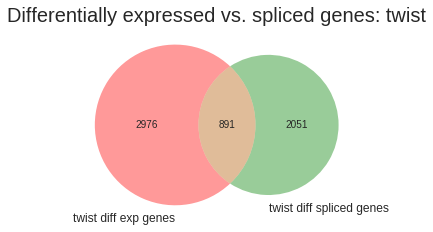

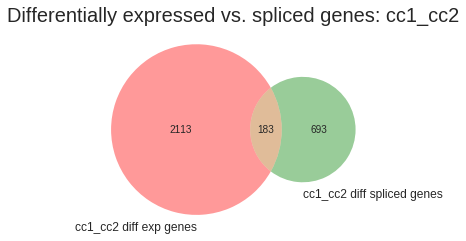

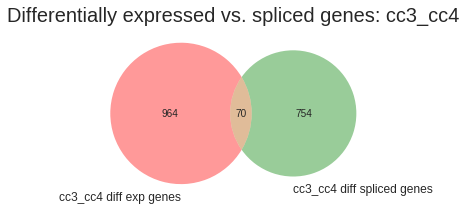

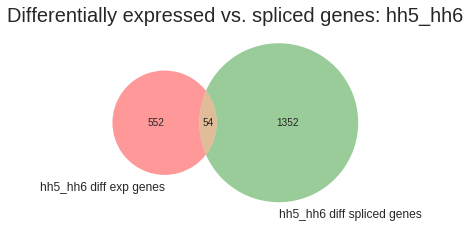

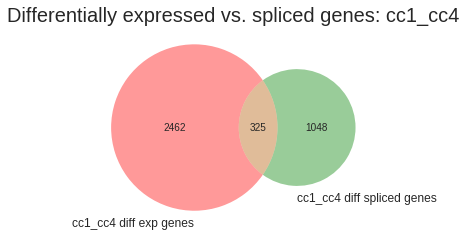

In [189]:
#This shows how many genes were splice and how many were differentially expressed between the samples
(twist_inter,twist_gene_diff_only,twist_splice_diff_only) = compare_genes_diff_and_spliced(twist_cuff_df_filtered,twist_rMATS_df_filtered,'twist')
(cc1_cc2_inter,cc1_cc2_gene_diff_only,cc1_cc2_splice_diff_only) = compare_genes_diff_and_spliced(cc1_cc2_cuff_df_filtered,cc1_cc2_rMATS_df_filtered,'cc1_cc2')
(cc3_cc4_inter,cc3_cc4_gene_diff_only,cc3_cc4_splice_diff_only) = compare_genes_diff_and_spliced(cc3_cc4_cuff_df_filtered,cc3_cc4_rMATS_df_filtered,'cc3_cc4')
(hh5_hh6_inter,hh5_hh6_gene_diff_only,hh5_hh6_splice_diff_only) = compare_genes_diff_and_spliced(hh5_hh6_cuff_df_filtered,hh5_hh6_rMATS_df_filtered,'hh5_hh6')

(cc1_cc4_inter,cc1_cc4_gene_diff_only,cc1_cc4_splice_diff_only) = compare_genes_diff_and_spliced(cc1_cc4_cuff_df_filtered,cc1_cc4_rMATS_df_filtered,'cc1_cc4')

<matplotlib_venn._common.VennDiagram instance at 0x7fdbf90c1560>

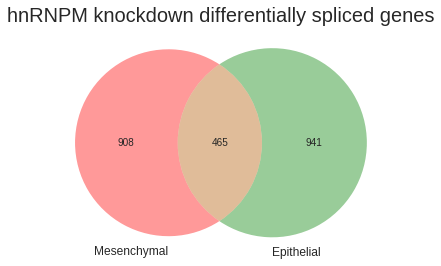

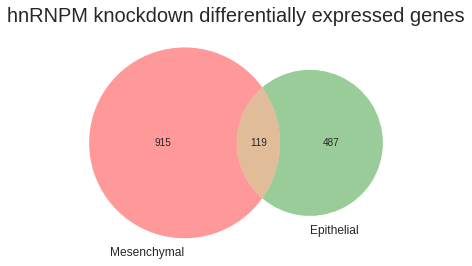

In [261]:
#THIS USES THE COMBINED CC TO MAKE A MASTER MESENCHYMAL SET VS THE EPITHELIAL SET

#combine the set of spliced from hnRNPM cc1_cc2
cc1_cc2_set = set(cc1_cc2_rMATS_df_filtered.ens_gene.tolist())
cc3_cc4_set = set(cc3_cc4_rMATS_df_filtered.ens_gene.tolist())
#combine
cc1_cc4_set = cc1_cc2_set.union(cc3_cc4_set)

hh5_hh6_set = set(hh5_hh6_rMATS_df_filtered.ens_gene.tolist())

#splicing venn diagram
fig = plt.figure(figsize=(6,6))
plt.title('hnRNPM knockdown differentially spliced genes',fontsize=20)
mplv.venn2([cc1_cc4_set,hh5_hh6_set],set_labels=('Mesenchymal','Epithelial'))

#combine the set of genes
cc1_cc2_gene_set = set(cc1_cc2_cuff_df_filtered.ens_gene.tolist())
cc3_cc4_gene_set = set(cc3_cc4_cuff_df_filtered.ens_gene.tolist())
#combine
cc1_cc4_gene_set = cc1_cc2_gene_set.union(cc3_cc4_gene_set)

hh5_hh6_gene_set = set(hh5_hh6_cuff_df_filtered.ens_gene.tolist())

#gene venn diagram
fig = plt.figure(figsize=(6,6))
plt.title('hnRNPM knockdown differentially expressed genes',fontsize=20)
mplv.venn2([cc3_cc4_gene_set,hh5_hh6_gene_set],set_labels=('Mesenchymal','Epithelial'))


In [158]:
def compare_spliced_and_spliced(cuff_df,mats_df,sample_name_1,sample_name_2):
    plt.figure(figsize=(5,5))
    plt.title('Differentially spliced genes: '+sample_name_1+'_vs_'+sample_name_2,fontsize=20)
    cuff_set = set(cuff_df.ens_gene.tolist())
    cuff_list = list(cuff_set)
    cuff_list.insert(0,sample_name_1+'_all_spliced_genes')
    mats_set = set(mats_df.ens_gene.tolist())
    mats_list = list(mats_set)
    mats_list.insert(0,sample_name_2+'_all_spliced_genes')
    intersection = list(cuff_set.intersection(mats_set))
    intersection.insert(0,sample_name_1+'_'+sample_name_2+'_intersection')
    gene_diff_only = list(cuff_set.difference(mats_set))
    gene_diff_only.insert(0,sample_name_1+'_splice_only')
    splice_diff_only = list(mats_set.difference(cuff_set))
    splice_diff_only.insert(0,sample_name_2+'_splice_only')
    mplv.venn2([set(cuff_df.ens_gene.tolist()),set(mats_df.ens_gene.tolist())],set_labels=(sample_name_1+' diff spliced genes',sample_name_2+' diff spliced genes'))
    
    #combine the list
    megalist = [cuff_list,mats_list,intersection,gene_diff_only,splice_diff_only]
    
    #now write to file
    with open('master_go_analysis/'+sample_name_1+'_vs_'+sample_name_2+'_splicing.txt','w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(izip_longest(*megalist,fillvalue=""))

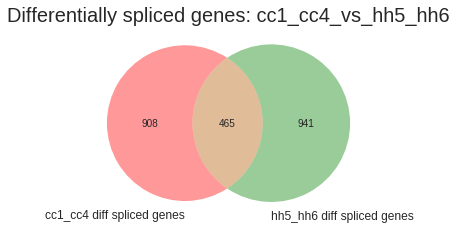

In [192]:
compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'cc1_cc4','hh5_hh6')

In [198]:
def compare_gene_and_gene(cuff_df,mats_df,sample_name_1,sample_name_2):
    plt.figure(figsize=(5,5))
    plt.title('Differentially expressed genes: '+sample_name_1+'_vs_'+sample_name_2,fontsize=20)
    cuff_set = set(cuff_df.ens_gene.tolist())
    cuff_list = list(cuff_set)
    cuff_list.insert(0,sample_name_1+'_all_diff_genes')
    mats_set = set(mats_df.ens_gene.tolist())
    mats_list = list(mats_set)
    mats_list.insert(0,sample_name_2+'_all_diff_genes')
    intersection = list(cuff_set.intersection(mats_set))
    intersection.insert(0,sample_name_1+'_'+sample_name_2+'_intersection')
    gene_diff_only = list(cuff_set.difference(mats_set))
    gene_diff_only.insert(0,sample_name_1+'_gene_diff_only')
    splice_diff_only = list(mats_set.difference(cuff_set))
    splice_diff_only.insert(0,sample_name_2+'_gene_diff_only')
    mplv.venn2([set(cuff_df.ens_gene.tolist()),set(mats_df.ens_gene.tolist())],set_labels=(sample_name_1+' diff exp genes',sample_name_2+' diff exp genes'))
    
    #combine the list
    megalist = [cuff_list,mats_list,intersection,gene_diff_only,splice_diff_only]
    
    #now write to file
    with open('master_go_analysis/'+sample_name_1+'_vs_'+sample_name_2+'_gene_exp.txt','w') as f:
        writer = csv.writer(f,'textdialect')
        writer.writerows(izip_longest(*megalist,fillvalue=""))

In [270]:
#write a function to go into the david output and collect the data for the 3 bar graphs and then plot
#How am I going to do this. Pull everything out as a dataframe
def david_bar_graph(david_sample_1_file,david_sample_2_file,david_intersection_file,sample_1,sample_2,id_of_interest,cutoff):
    sample_1_only = pd.read_csv(david_sample_1_file,sep='\t')
    sample_2_only = pd.read_csv(david_sample_2_file,sep='\t')
    intersection = pd.read_csv(david_intersection_file,sep='\t')

    #collect only the GOTERM_BP_DIRECT
    def collect_id_of_interest(id_of_interest,dataframe):
        dataframe = dataframe[dataframe.Category == id_of_interest]
        return dataframe

    id_of_interest = 'GOTERM_BP_DIRECT'

    sample_1_only = collect_id_of_interest(id_of_interest,sample_1_only)
    sample_2_only = collect_id_of_interest(id_of_interest,sample_2_only)
    intersection = collect_id_of_interest(id_of_interest,intersection)

    #now need to filter by a neg_log_p value
    def neg_log_p_and_filter_go(cutoff,dataframe):
        dataframe['neglogP'] = dataframe.apply(lambda row: -1*log(row['PValue'],10),axis=1)
        dataframe = dataframe[dataframe.neglogP > cutoff]
        return dataframe

    cutoff = 3

    sample_1_only = neg_log_p_and_filter_go(cutoff,sample_1_only)
    sample_2_only = neg_log_p_and_filter_go(cutoff,sample_2_only)
    intersection = neg_log_p_and_filter_go(cutoff,intersection)

    #now blot a bar graph for each one
    fig,ax = plt.subplots(3,1,figsize=(10,20),sharey=False)
    sample_1_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[0],label=sample_1+'_only',color='b')
    sample_2_only.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[1],label=sample_2+'_only',color='r')
    intersection.plot.barh(x='Term',y='neglogP',fontsize=15,ax=ax[2],label=sample_1+'_and_'+sample_2,color='g')


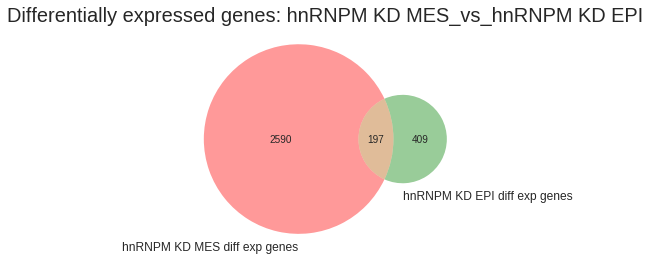

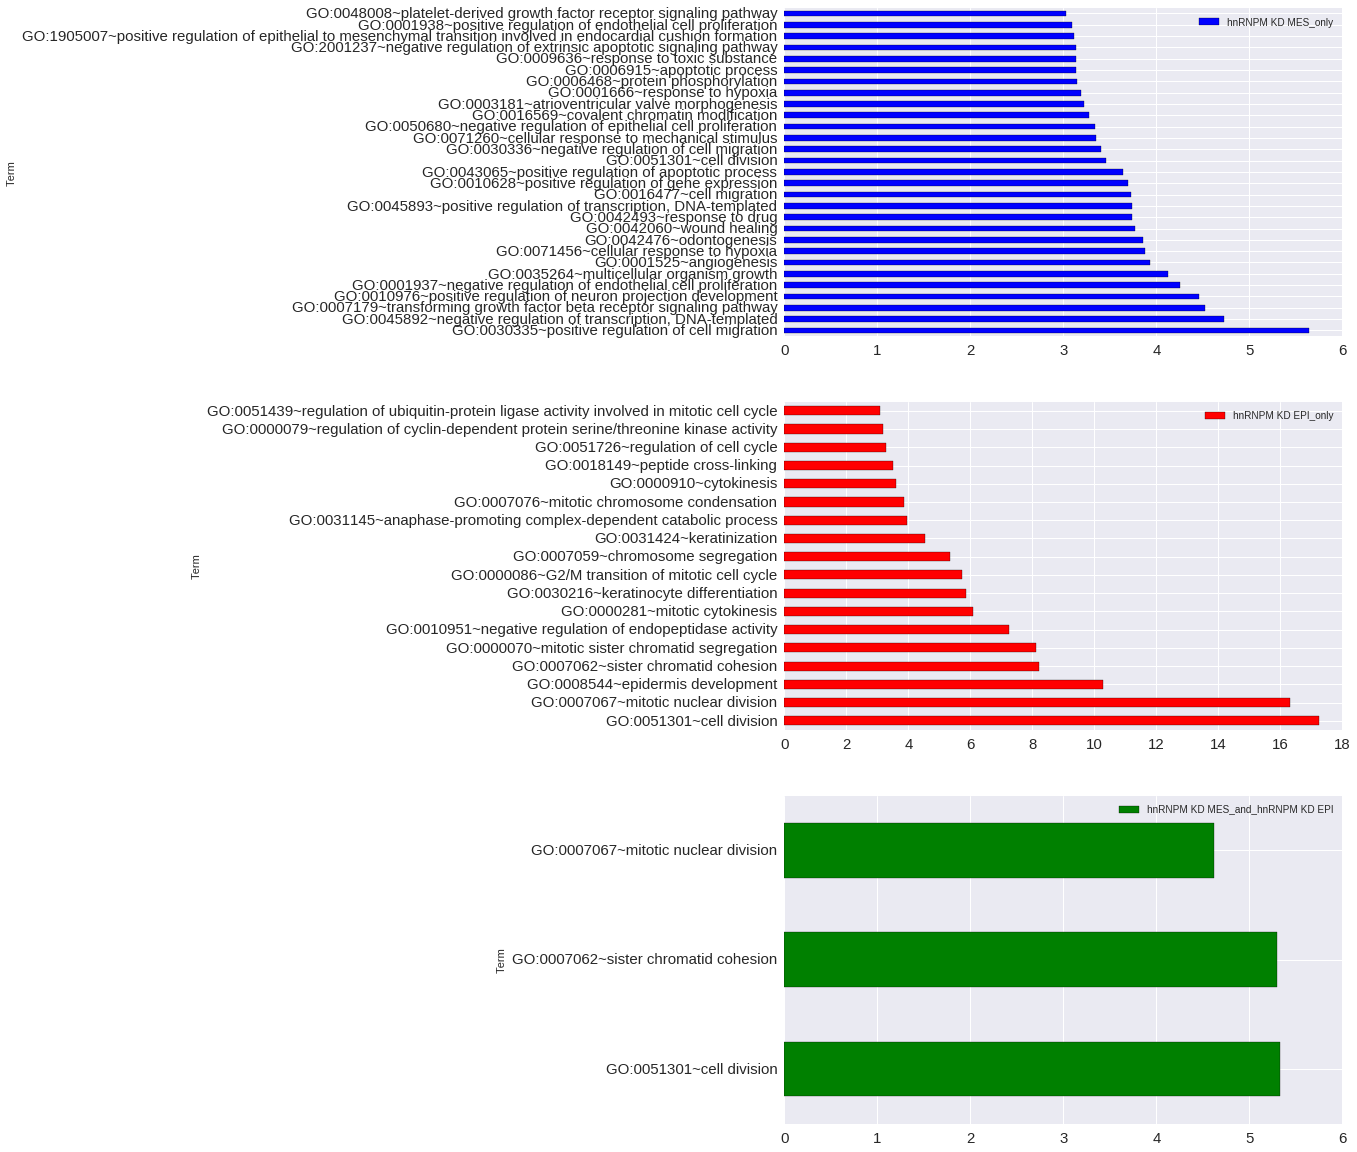

In [271]:
#EPI VS MES GENE EXPRESSION
cc1_cc4_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_gene_diff_only.txt'
hh5_hh6_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/hh5_hh6_gene_diff_only.txt'
both_gene = 'master_go_analysis/epi_vs_mes_hnM_knockdown_genes_diff_log_ratio_1/cc1_cc4_hh5_hh6_intersection_gene.txt'
compare_gene_and_gene(cc1_cc4_cuff_df_filtered,hh5_hh6_cuff_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_gene,hh5_hh6_gene,both_gene,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',3)

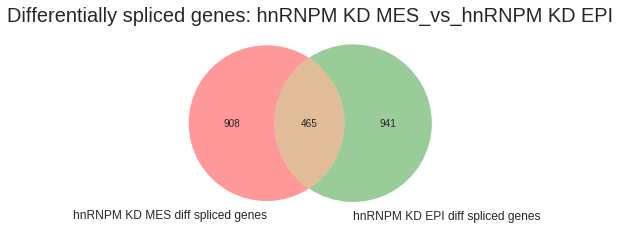

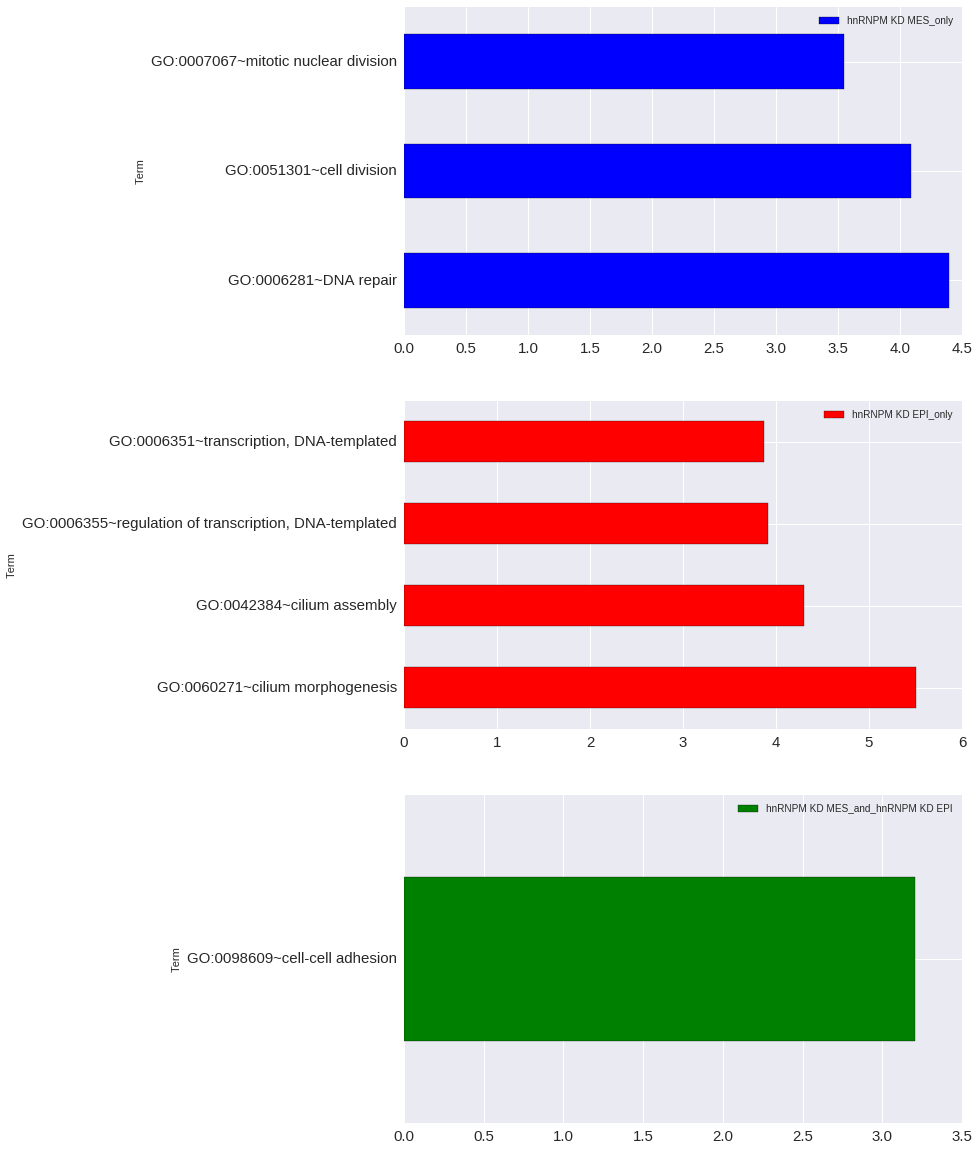

In [272]:
#EPI VS MES SPLICING
cc1_cc4_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_splice_only.txt'
hh5_hh6_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/hh5_hh6_splice_only.txt'
both_splice = 'master_go_analysis/epi_vs_mes_hnM_knockdown_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_hh5_hh6_intersection_splice.txt'
compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_splice,hh5_hh6_splice,both_splice,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',1.5)

TypeError: Empty 'DataFrame': no numeric data to plot

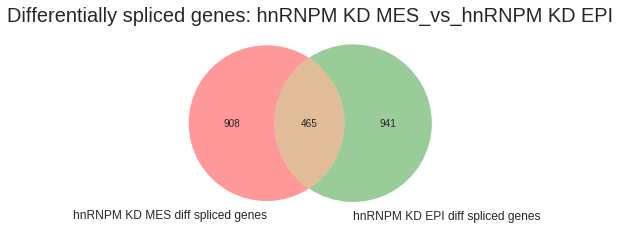

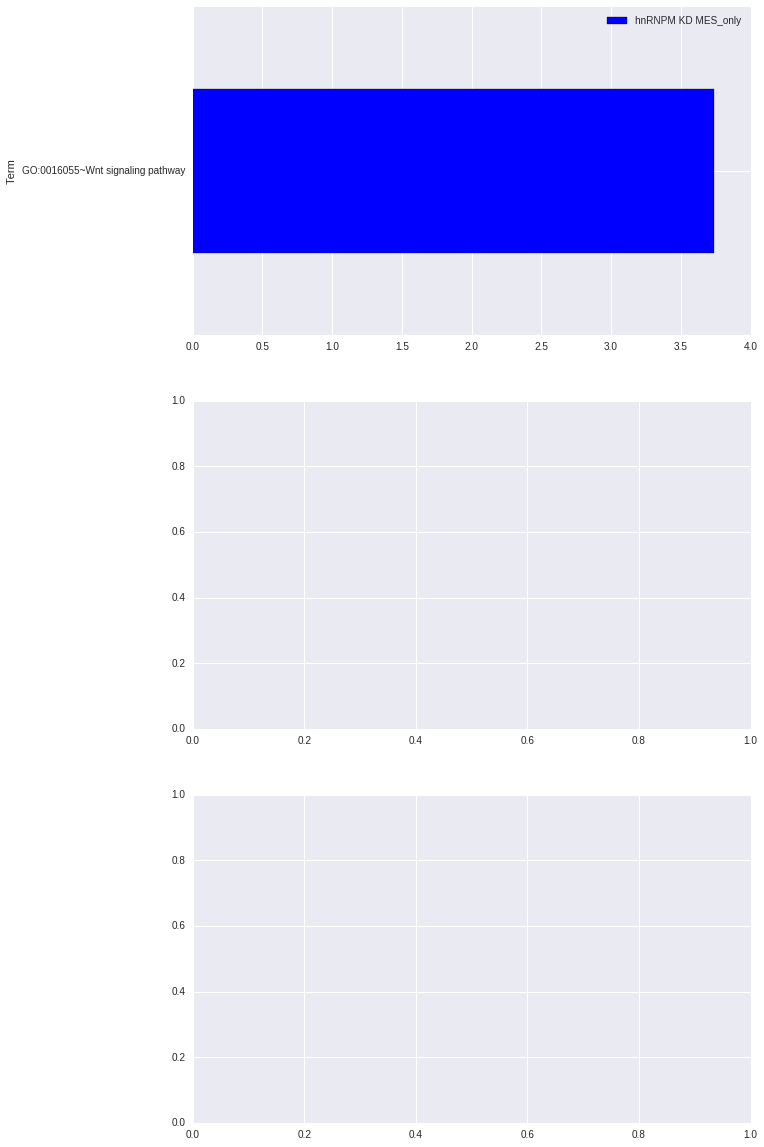

In [265]:
#EPI VS MES SPLICING BOUND
cc1_cc4_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_v_intersect_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_v_intersect_spliced_only.txt'
hh5_hh6_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_v_intersect_splice_diff_fdr_0.05_dPSI_0.1/hh5_hh6_v_intersect_spliced_only.txt'
both_splice = 'master_go_analysis/epi_vs_mes_hnM_KD_v_intersect_splice_diff_fdr_0.05_dPSI_0.1/cc1_cc4_hh5_hh6_v_intersect_spliced.txt'
compare_spliced_and_spliced(cc1_cc4_rMATS_df_filtered,hh5_hh6_rMATS_df_filtered,'hnRNPM KD MES','hnRNPM KD EPI')
david_bar_graph(cc1_cc4_splice,hh5_hh6_splice,both_splice,'hnRNPM KD MES','hnRNPM KD EPI','GOTERM_BP_DIRECT',0.01)

In [ ]:
#Other GO lists to do
#differentially bound genes
#differentially bound splicing events
#for each of these compare epi and compare mes

#Then get into the weeds... bound vs. unbound in each condition as well as those associated with gene expression or splicing in a particular direction during EMT

In [ ]:
#import the differentially bound genes
